In [1]:
import importlib
import sys
from urllib.request import urlretrieve


# python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from sympy import Matrix

import pydrake.all

# pydrake imports
from pydrake.common.containers import namedview
from pydrake.systems.scalar_conversion import TemplateSystem
from pydrake.all import (Variable, SymbolicVectorSystem, VectorSystem, DiagramBuilder,
                         LogOutput, Simulator, ConstantVectorSource,
                         MathematicalProgram, Solve, SnoptSolver, PiecewisePolynomial, eq, cos, sin, 
                         DirectTranscription, DirectCollocation)
from pydrake.systems.framework import (BasicVector, BasicVector_, LeafSystem_,
                                       LeafSystem)
import pydrake.symbolic as sym

from lyapunov_control import *
from trajopt_control import *

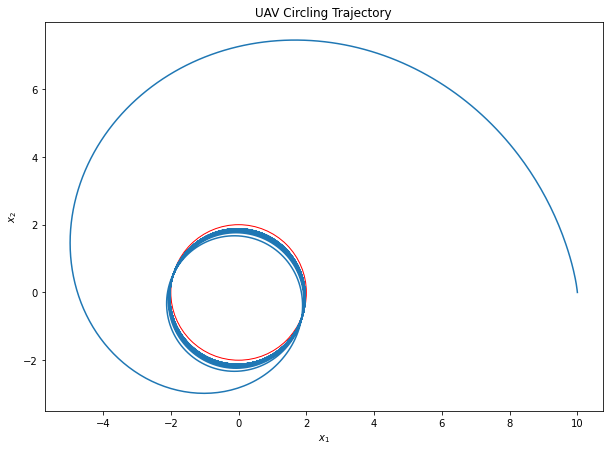

In [2]:
x0 = np.array([10, 0, np.pi/2+.1])
xf = np.array([0, 0, 0])


simulator, dat = lyapunov_simulation(x0, xf, )

draw_simulation(dat, xf, 2)

(401, 3)


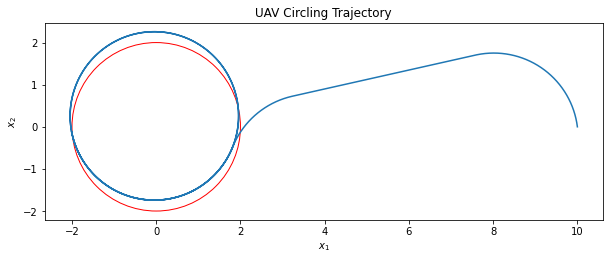

In [3]:
x_opt, u_opt = trajopt_simulation(x0, xf)
draw_simulation(x_opt, xf, 2)


http://michalcap.net/wp-content/papercite-data/pdf/paden_2016.pdf

(401,)
0


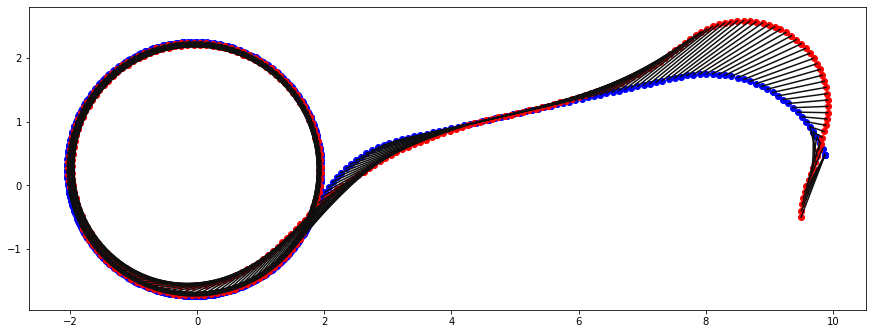

In [8]:
dt = 0.1
k = 1
x0 = np.array([9.5, -0.5, np.pi/2.])
n_points = np.shape(x_opt)[1]
x_traj = np.zeros(np.shape(x_opt))
plt.figure(figsize=(15, 15))

x0_long = np.repeat(x0.reshape(3, 1), n_points, axis=1)
differences = np.linalg.norm(x_opt[:2,:] - x0_long[:2,:], axis=0)
print(np.shape(differences))
idx_min_diff = np.argmin(np.linalg.norm(x_opt[:2,:] - x0_long[:2,:], axis=0))
print(idx_min_diff)

close = False

i = 0

while i < n_points:
    if not close:
        x0_long = np.repeat(x0.reshape(3, 1), n_points, axis=1)
        differences = np.linalg.norm(x_opt[:2,:] - x0_long[:2,:], axis=0)
        idx_min_diff = np.argmin(differences)

        if differences[idx_min_diff] < 0.1:
            close = True
            i = idx_min_diff
            xf = x_opt[:,min(i+1, n_points-1)]
            uf = u_opt[min(i, n_points-2)]
        else:
            xf = x_opt[:,min(idx_min_diff+5, n_points-1)] # added a lookahead
            uf = u_opt[min(idx_min_diff+4, n_points-2)]
    else:
        xf = x_opt[:,min(i+1, n_points-1)]
        uf = u_opt[min(i, n_points-2)]
    
    plt.plot([x0[0], xf[0]], [x0[1], xf[1]], c='#0f0f0f')
    plt.scatter(xf[0], xf[1], c='b')
    plt.scatter(x0[0], x0[1], c='r')

    simulator, dat = lyapunov_simulation(x0, xf, uf, to_point=True)
    
    x0 = dat[:,-1]
    x_traj[:,i] = dat[:,-1]
    
    i += 1
        

plt.gca().set_aspect('equal')

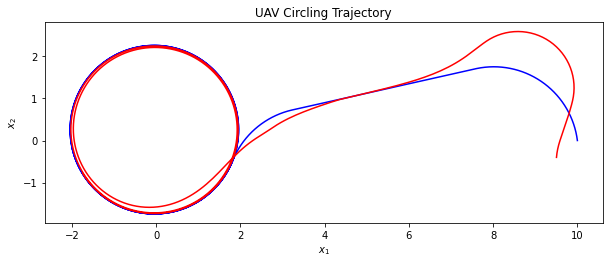

In [9]:
draw_comparison(x_opt[:,:-1], x_traj[:,:-2])

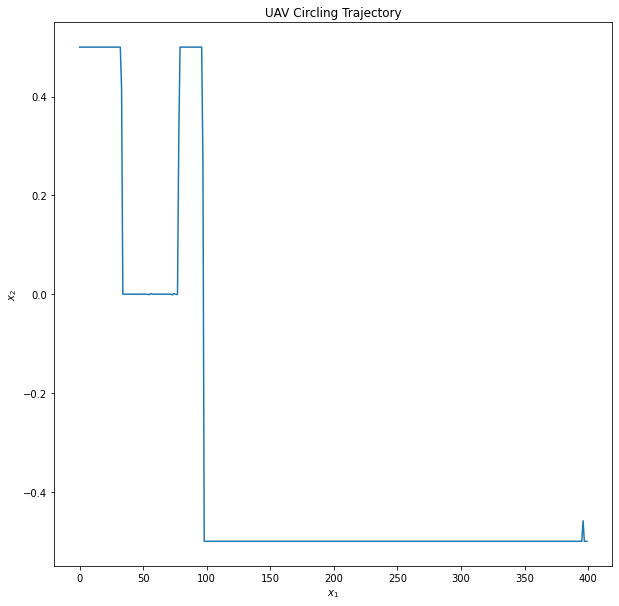

In [6]:
plt.figure(figsize=(10, 10))
fig  = plt.gcf()
ax = plt.gca()
t = np.linspace(0, 400, int(400/0.1))

plt.plot(u_opt)
# circle1 = plt.Circle((xf[0], xf[2]), r, color='r', fill=False)

# ax.add_patch(circle1)

# misc plot settings
# plt.gca().set_aspect('equal')
# plt.legend()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('UAV Circling Trajectory');